In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io


In [8]:
# load mat file
import scipy.io as sio
mat_contents = sio.loadmat('data/omer_Pilot_continous_psych_2023-09-26_00h46.01.195.mat')
mat_contents.keys()
sigma=mat_contents['sigma']
target=mat_contents['target'] # velocity of target motion for 1200 frames (20 seconds) and 30 trials
response=mat_contents['response'] # velocity of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_x=mat_contents['mouse_x'] # x position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_y=mat_contents['mouse_y'] # y position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
blob_x=mat_contents['blob_x'] # x position of target for 1200 frames (20 seconds) and 30 trials
blob_y=mat_contents['blob_y'] # y position of target for 1200 frames (20 seconds) and 30 trials

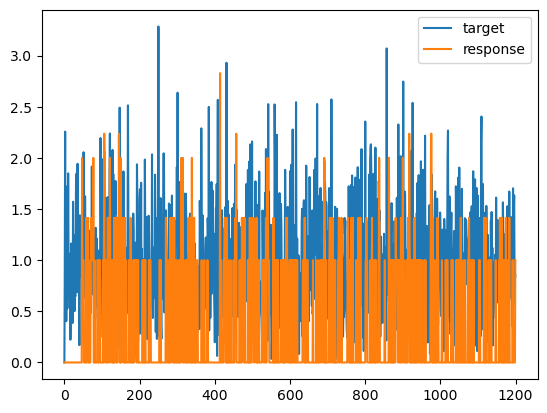

In [11]:
# plot the data
plt.plot(target[0,:])
plt.plot(response[0,:])
plt.legend(['target','response'])
plt.show()


In [27]:
sigma
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(30):
    trial_dict[i] = {'target': target[i,:], 'response': response[i,:], 'mouse_x': mouse_x[i,:], 'mouse_y': mouse_y[i,:], 'blob_x': blob_x[i,:], 'blob_y': blob_y[i,:]}


{'target': array([0.        , 1.2717955 , 0.9513568 , ..., 0.43835457, 0.4328908 ,
        0.89681967]),
 'response': array([0.        , 5.38516481, 6.32455532, ..., 1.        , 1.        ,
        1.        ]),
 'mouse_x': array([ -7., -12., -18., ..., -32., -31., -30.]),
 'mouse_y': array([  3.,   5.,   7., ..., -21., -21., -21.]),
 'blob_x': array([  0.        ,   1.07864542,   0.32636751, ..., -27.07312771,
        -27.42287449, -26.63546907]),
 'blob_y': array([  0.        ,  -0.6737862 ,  -1.25615868, ..., -24.8280863 ,
        -25.08317771, -25.51245412])}

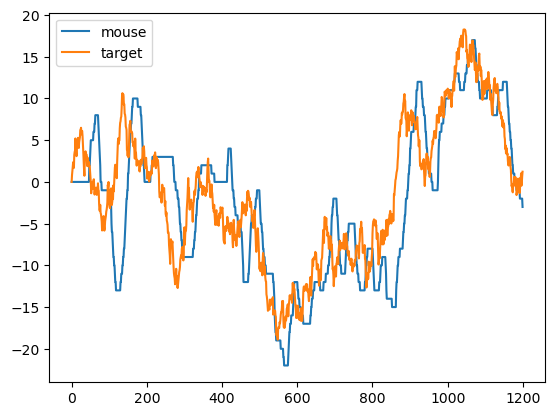

In [15]:
# plot motion trajectory for a single trial
trialNum=0
plt.plot(mouse_x[trialNum,:])
plt.plot(blob_x[trialNum,:])
plt.legend(['mouse','target'])
plt.show()


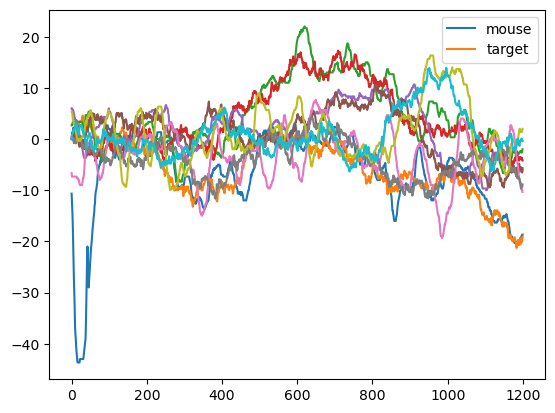

In [29]:
# avarage motion trajectory for trials with the same sigma value
for i in range(0,5):
    # get mean of mouse_x for trials untill sigma value changes
    mean_mouse_x = np.mean(mouse_x[i*3:(i+1)*3,:], axis=0)
    # get mean of blob_x for trials untill sigma value changes
    mean_blob_x = np.mean(blob_x[i*3:(i+1)*3,:], axis=0)
    # plot the mean of mouse_x and blob_x
    plt.plot(mean_mouse_x)
    plt.plot(mean_blob_x)
    plt.legend(['mouse','target'])

plt.show()

In [99]:
# dictionary of 5 sigma values and trialNums
sigma_dict = {11: 0, 13: 1, 25: 2, 17:3,29:4,21:5}
sigma

array([[11, 11, 11, 11, 11, 13, 13, 13, 13, 13, 25, 25, 25, 25, 25, 17,
        17, 17, 17, 17, 29, 29, 29, 29, 29, 21, 21, 21, 21, 21]])

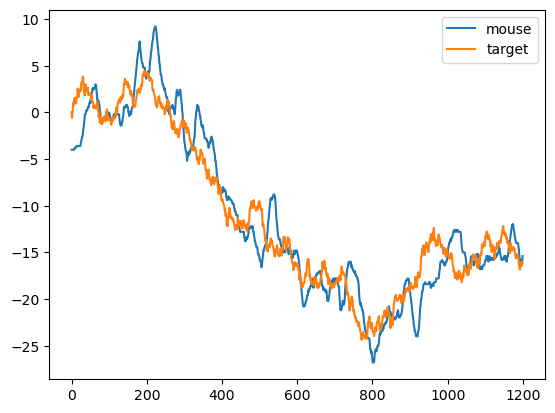

In [60]:
# sigma is blob width of the target on each trial
# sigma is constant for 5 trials and then changes
# calculate mean of mouse_x and blob_x for trials with the same sigma value
# plot the mean of mouse_x and blob_x for trials with the same sigma value  (5 plots)
mean_mouse_xs=[]
mean_blob_xs=[]
mean_mouse_ys=[]
mean_blob_ys=[]
mean_mouse_vs=[]
mean_blob_vs=[]
for i in range(0,6):
    # get mean of mouse_x for trials untill sigma value changes
    mean_mouse_xs.append(np.mean(mouse_x[i*5:(i+1)*5,:], axis=0))
    # get mean of blob_x for trials untill sigma value changes
    mean_blob_xs.append( np.mean(blob_x[i*5:(i+1)*5,:], axis=0))
    mean_blob_ys.append( np.mean(blob_y[i*5:(i+1)*5,:], axis=0))
    mean_mouse_ys.append( np.mean(mouse_y[i*5:(i+1)*5,:], axis=0))
    mean_mouse_vs.append( np.mean(response[i*5:(i+1)*5,:], axis=0))
    mean_blob_vs.append( np.mean(target[i*5:(i+1)*5,:], axis=0))
    
# plot the mean of mouse_x and blob_x
plt.plot(mean_mouse_xs[sigma_dict[21]])
plt.plot(mean_blob_xs[sigma_dict[21]])
# color the plot with the same color for the same sigma value

plt.legend(['mouse','target'])

# Cross Correlogram

In [98]:
sigma_dict[11]

TypeError: 'int' object is not subscriptable

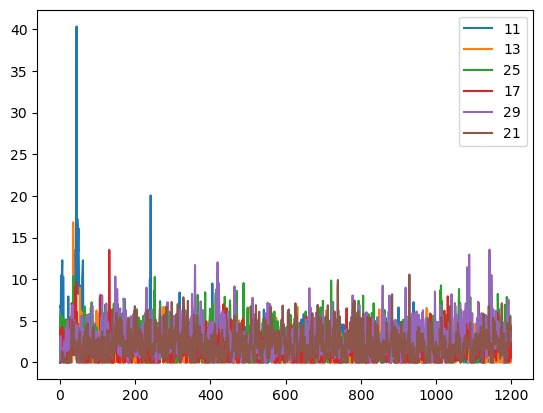

In [122]:
# avarage cross correlogram of velocity of mouse and target motion for trials with the same sigma valu
# Figure 4. Average CCGs for blob width (curve color, identified in the legend by their r in arcmin) for each of the three observers (panel). The peak height, location of peak, and width of curve (however measured) all sort neatly by blob width, with the more visible targets yielding higher, prompter, and sharper curves. This shows that there is at least a qualitative agreement between measures of tracking performance and what would be expected from a traditional psychophysical experiment

# calculate correlation of blob_v and mouse_v value across 1200 frames 
# correlation_across_frames=[]
# blob_width=sigma_dict[13]
# for i in range(1200):
#     correlation_across_frames.append(np.correlate(target[blob_width*5:(blob_width+1)*5,i], response[blob_width*5:(blob_width+1)*5,i]))
# # plot the correlation
# plt.plot(correlation_across_frames)
# plt.show()
import scipy.signal  

##
# now create cross correlogram plot for each blob width and label them with blob width
for sigma in sigma_dict.keys():
    blob_width=sigma_dict[sigma]
    correlation_across_frames=[]    
    for i in range(1200):
        correlation_across_frames.append(np.correlate(target[blob_width*5:(blob_width+1)*5,i], response[blob_width*5:(blob_width+1)*5,i]))
    # plot the correlation
    plt.plot(correlation_across_frames, label=sigma)
plt.legend()
plt.show()
